# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [19]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [ ]:
# import scipy.io as sio
# import Event_Handle_red as  eh
# # import hdf5storage
# # datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total_2_distancias_red.mat')
# # conjunto_datos= datos_matlab.get('photodefbox2_todo_fil5')

# # npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# # npzfile.files
# path = "/home/rgadea/experimentos/viherbos/"
# data_file = "MOVIE_DATA_batch1.h5"
# json_file = "CUBE.json"
# def cart2pol(x, y,z):
#     rho = np.sqrt(x**2 + y**2)
#     phi = np.arctan2(y, x)
#     return(rho, phi,z)


# pepito=eh.Event_Handler(path, data_file, json_file)
# prueba=pepito(7)
# veamos=prueba['TRUE1']
# polares=cart2pol(veamos[0], veamos[1], veamos[2])
# print(np.asarray(polares))

# idea=pepito.DATA_A.shape #obtengo el numero de muestras

# entradas_sensorsA1=np.zeros([idea[0],20,175])
# entradas_sensorsB1=np.zeros([idea[0],20,175])
# coordenadas1=np.zeros([idea[0],3])
# entradas_sensorsA2=np.zeros([idea[0],20,175])
# entradas_sensorsB2=np.zeros([idea[0],20,175])
# coordenadas2=np.zeros([idea[0],3])
# for i in range(idea[0]):
#     DATA=pepito(i)
#     entradas_sensorsA1[i]=DATA['DATA_A1'];
#     entradas_sensorsB1[i]=DATA['DATA_B1'];    
#     veamos=DATA['TRUE1']
#     polares=cart2pol(veamos[0], veamos[1], veamos[2])
#     coordenadas1[i]=np.asarray(polares)
#     entradas_sensorsA2[i]=DATA['DATA_A2'];
#     entradas_sensorsB2[i]=DATA['DATA_B2'];    
#     veamos=DATA['TRUE2']
#     polares=cart2pol(veamos[0], veamos[1], veamos[2])
#     coordenadas2[i]=np.asarray(polares)

# np.savez('../conjuntos_datos_nuevos_2020/9_12_2019', entradas_sensorsA1,entradas_sensorsB1, coordenadas1,entradas_sensorsA2,entradas_sensorsB2, coordenadas2 )



## Network parameters:

In [22]:
npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019_filt.npz')
npzfile.files

conjunto_datos_entradasA=npzfile['arr_0']
conjunto_datos_entradasB=npzfile['arr_1']
conjunto_datos_salidas=npzfile['arr_2']


batch_size = 250
nb_classes = 10
nb_epoch = 1000

# input image dimensions
img_rows, img_cols = 20, 33
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (1,2, 2)
# convolution kernel size
kernel_size = (2, 3, 3)

## Prepare data into training and test set.

In [4]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2=np.zeros([muestras,20,175])
veamos2_3=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasA[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2A[i]=veamos2_3[i,:,indice_inferior:indice_superior]
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2B[i]=veamos2_3[i,:,indice_inferior:indice_superior]    

print('sector A shape:', sector2A.shape)
conjunto_datos_nuevoA=sector2A.reshape(sector2A.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', sector2B.shape)
conjunto_datos_nuevoB=sector2B.reshape(sector2B.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)

sector A shape: (15690, 20, 33)
conjunto_datos_nuevo A: (15690, 660)
sector B shape: (15690, 20, 33)
conjunto_datos_nuevo B: (15690, 660)


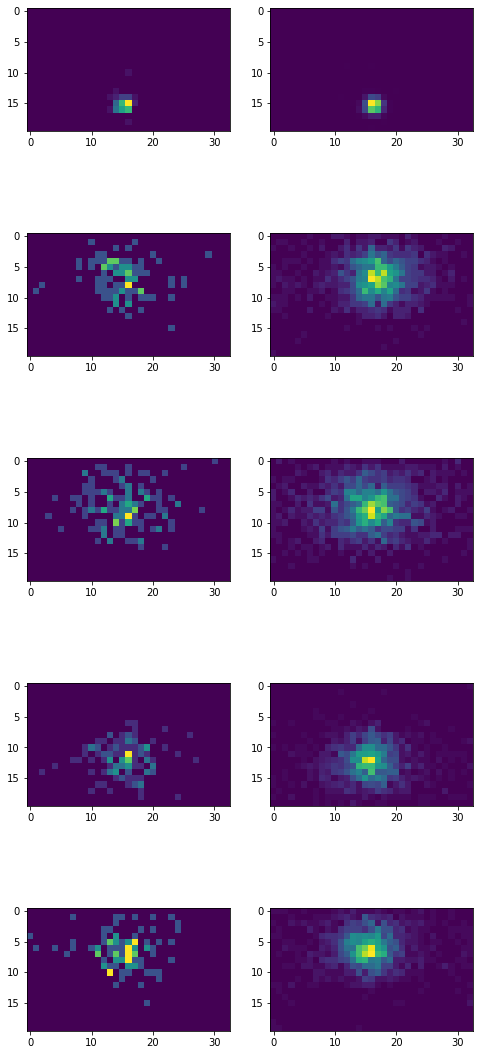

In [16]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


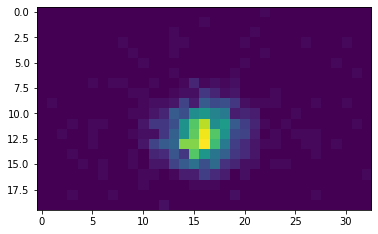

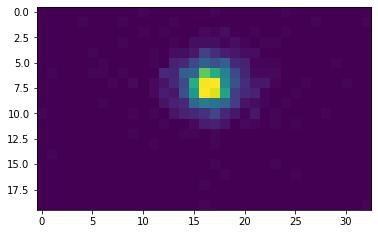

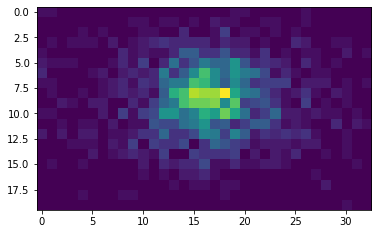

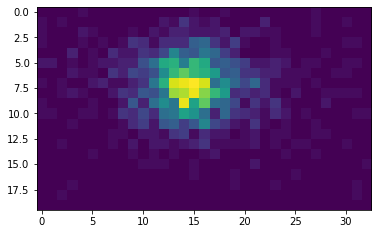

In [10]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [27]:
numero_muestras=muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas,conjunto_datos_nuevoB, conjunto_datos_nuevoA), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

9414
3138
3138
(971, 1320)
(799, 1320)
(612, 1320)
(461, 1320)
(295, 1320)


In [31]:


X_train = X_train.reshape(X_train.shape[0],2, img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], 2, img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], 2,img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], 2, img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], 2, img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], 2, img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], 2, img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], 2, img_rows, img_cols,1)

input_shape = (2, img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [32]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (9414, 2, 20, 33, 1)
9414 train samples
3138 validation samples
3138 test samples


Display 20 random training images using image

In [ ]:
# # convert class vectors to binary class matrices
# #Y_train = np_utils.to_categorical(y_train, nb_classes)
# #Y_test = np_utils.to_categorical(y_test, nb_classes)
# for i in range(1,5):
#     idea=np.random.randint(1,X_train.shape[0])
#     plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
#     plt.show()

## Build the CNN. 

In [33]:
model = Sequential()

model.add(Conv3D(8, kernel_size=kernel_size,
                        padding='same',
                        data_format='channels_last',
                        input_shape=(2,img_rows,img_cols,1)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(16, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(64, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(128, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

experimento="CNN_kernel_{}x{}x{}_con_batchnormalization_sector_{}x{}x{}".format(kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)
algoritmo='Nadam'

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error',
              optimizer=algoritmo)



Show a summary of the model parameters. 

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 2, 20, 33, 8)      152       
_________________________________________________________________
activation_3 (Activation)    (None, 2, 20, 33, 8)      0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 10, 16, 8)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 2, 10, 16, 16)     2320      
_________________________________________________________________
activation_4 (Activation)    (None, 2, 10, 16, 16)     0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 2, 5, 8, 16)       0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 5, 8, 32)       9248      
__________

And now train the model and evaluate on the test set. 

In [34]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                     callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 9414 samples, validate on 3138 samples
Epoch 1/1000
9414/9414 [==============================] - 11s 1ms/step - loss: 7413.0759 - val_loss: 863.4339
Epoch 2/1000
9414/9414 [==============================] - 1s 153us/step - loss: 1637.0764 - val_loss: 980.2757
Epoch 3/1000
9414/9414 [==============================] - 2s 231us/step - loss: 704.3833 - val_loss: 524.0993
Epoch 4/1000
9414/9414 [==============================] - 2s 239us/step - loss: 474.9068 - val_loss: 324.3179
Epoch 5/1000
9414/9414 [==============================] - 2s 168us/step - loss: 276.5283 - val_loss: 189.4583
Epoch 6/1000
9414/9414 [==============================] - 2s 176us/step - loss: 189.7583 - val_loss: 151.5122
Epoch 7/1000
9414/9414 [==============================] - 2s 165us/step - loss: 185.3370 - val_loss: 138.7456
Epoch 8/1000
9414/9414 [==============================] - 2s 185us/step - loss: 144.8264 - val_loss: 109.9525
Epoch 9/1000
9414/9414 

In [35]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [36]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 15.385380447404714
[176.23752 176.86143 183.0655  174.04979 176.43771 178.28271 180.13666
 170.09299 183.02919 168.74113]
[174.5623939  177.33907391 183.39877955 173.12611007 174.13642805
 180.89539968 180.6435829  169.9576098  182.34942791 169.37111112]
[-1.67512441  0.47763897  0.33327357 -0.92367936 -2.30128557  2.61268483
  0.50692519 -0.13537726 -0.67976215  0.62997647]


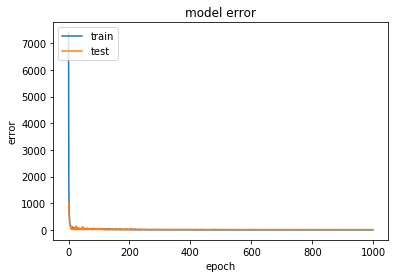

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


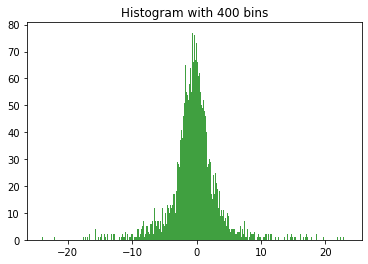

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 400
    # variables        = 3
    chi-square         = 4360.69265
    reduced chi-square = 10.9841125
    Akaike info crit   = 961.568657
    Bayesian info crit = 973.543051
[[Variables]]
    amp:  65.0347876 +/- 0.74432804 (1.14%) (init = 1000)
    cen: -0.39786189 +/- 0.02617001 (6.58%) (init = 0)
    wid:  2.80057633 +/- 0.03700999 (1.32%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



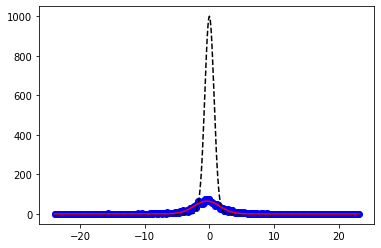

In [39]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [40]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [41]:
print(FWHM)

4.6632654788894925


[[170.09299]
 [168.74113]
 [171.9236 ]
 [166.27382]
 [170.98633]
 [172.27126]
 [170.7428 ]
 [167.03821]
 [168.04018]
 [170.49905]
 [167.73772]
 [172.00291]
 [169.63622]
 [168.6406 ]
 [170.4524 ]
 [169.51451]
 [178.04353]
 [175.41624]
 [168.45844]
 [166.7439 ]
 [165.99036]
 [168.83429]
 [165.12312]
 [169.73532]
 [171.45576]
 [168.93047]
 [170.79938]
 [172.8489 ]
 [169.36035]
 [167.46307]
 [174.65628]
 [170.33824]
 [168.68808]
 [167.3936 ]
 [170.1778 ]
 [167.83395]
 [164.4708 ]
 [168.96524]
 [180.20544]
 [170.21902]
 [176.70772]
 [167.17862]
 [168.72878]
 [176.43398]
 [169.3733 ]
 [168.83318]
 [175.76488]
 [168.98776]
 [168.27576]
 [170.71054]
 [170.31773]
 [167.46391]
 [168.50955]
 [185.08575]
 [166.83995]
 [168.71349]
 [167.76413]
 [168.7852 ]
 [171.04283]
 [178.08235]
 [170.32713]
 [170.46657]
 [170.00017]
 [166.81126]
 [173.46667]
 [172.34883]
 [168.15611]
 [167.5016 ]
 [164.4854 ]
 [180.5169 ]
 [168.01021]
 [184.70662]
 [169.85687]
 [168.15593]
 [176.75682]
 [170.36487]
 [166.92648]

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.154221561961074


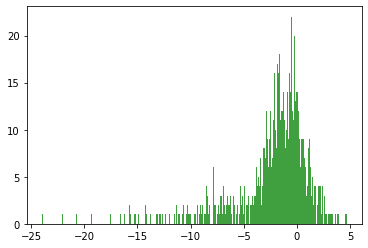

In [42]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.709017171404316


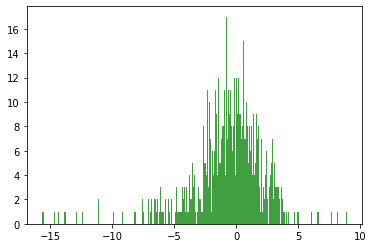

In [43]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.585669169314222


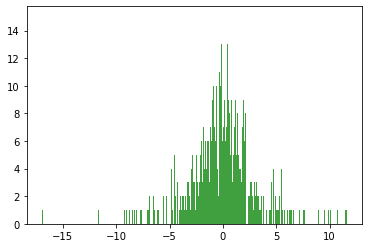

In [44]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.648081759836555


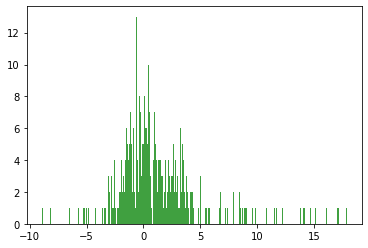

In [45]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


6.21443784393621
4.648081759836555
4.585669169314222
4.709017171404316
4.154221561961074


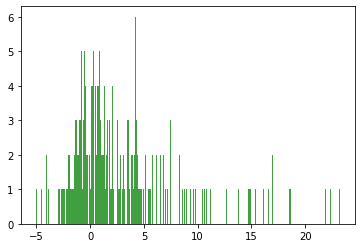

In [46]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan